# Multiclass Classification of COVID-19/Normal/Pneumonia X-Rays's with VGG16

# Installing new Libraries

In [1]:
!pip3 install imutils

You should consider upgrading via the 'C:\Users\Vineet\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
c
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import shutil
import random
import cv2
import argparse
import os

In [3]:
## To make the code run faster we use the GPU(Graphics Processing Unit of the machine)
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100


GPU device not found
Found GPU at: 


In [4]:
dataset_path = "E:\Studies\Minor Data"

In [5]:
%%bash
rm -rf dataset 
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p dataset/new

Couldn't find program: 'bash'


In [6]:
covid_19_path = "E:\Minor Project\Covid_19"
pneumonia_dataset_path = "E:\Minor Project\chest_xray"

# Exploratory Data Analysis of COVID Data Set

In [7]:
eda = pd.read_csv("E:\Minor Project\Covid_19\metadata.csv")

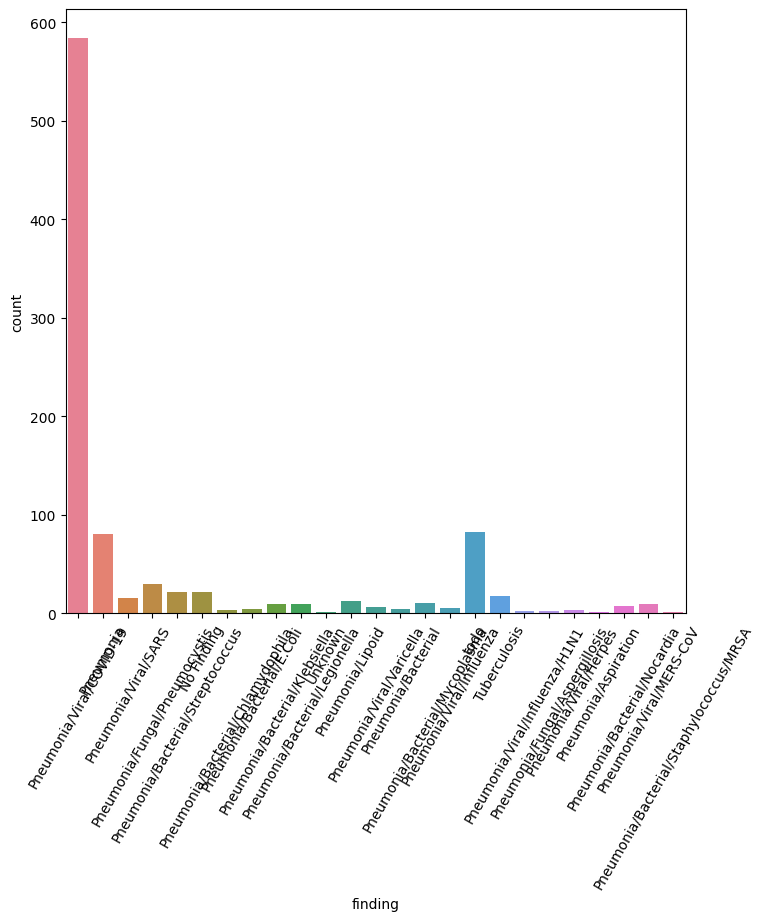

In [8]:
sns.countplot(x = 'finding', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.show()

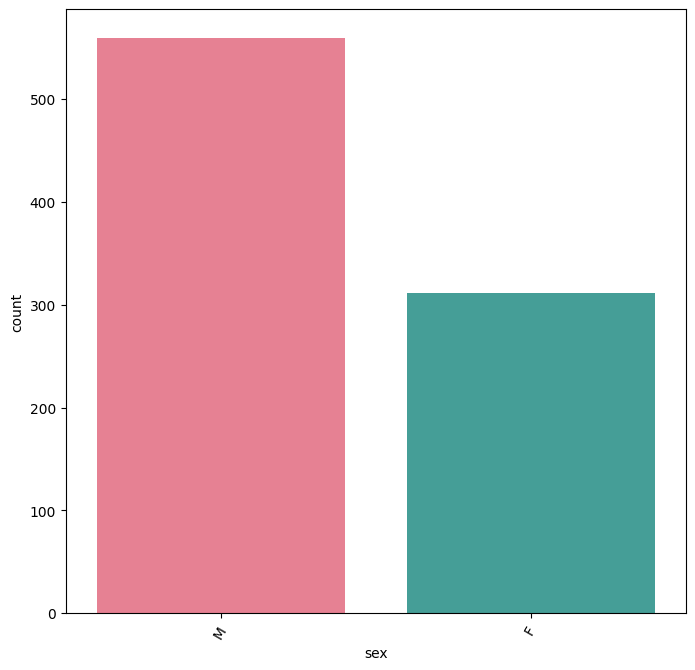

In [9]:
sns.countplot(x = 'sex', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.show()

# Creating The Data Set

In [10]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_19_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "Pneumonia/Viral/COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_19_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [11]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

# X-Ray Show

In [12]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/pneumonia"))

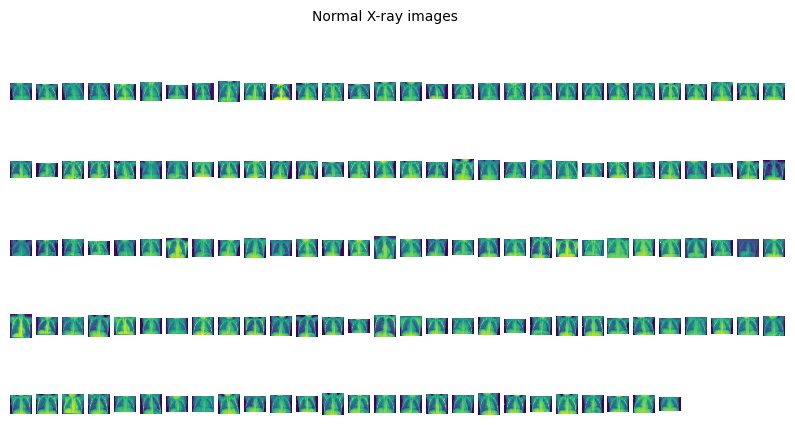

In [13]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

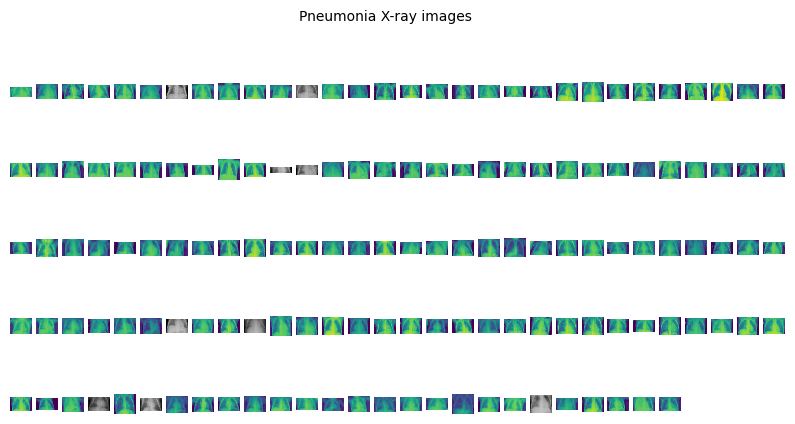

In [14]:
plots_from_files(pneumonia_images, rows=5, maintitle="Pneumonia X-ray images")

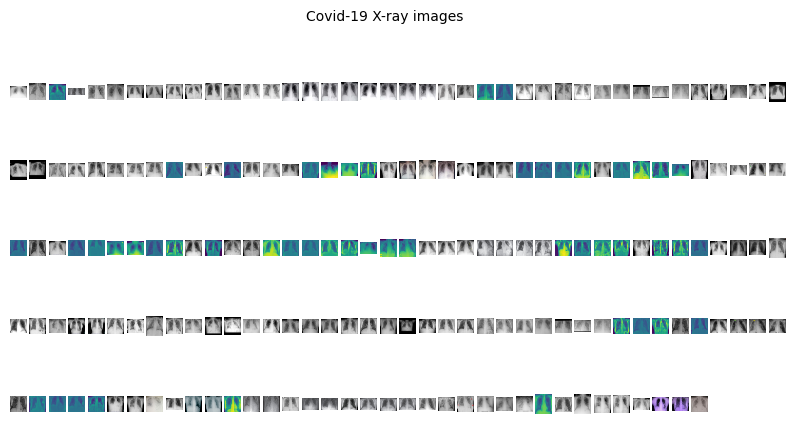

In [15]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

# Data PreProcessing


In [16]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [17]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images...
[INFO] Images successfully loaded


In [18]:
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)



X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels,random_state = 42)



trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')

# Making the VGG16 model

In [19]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size =(4, 4))(headmodel)
headmodel = Flatten(name ='Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False


opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


C:\Users\Vineet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
with tf.device('/cpu:0'):
    print("Training the model with cpu . . .")
    training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=30)

Training the model with cpu . . .


C:\Users\Vineet\AppData\Local\Temp\ipykernel_13560\1739741962.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=30)


Epoch 1/30
48/48 [==============================] - 58s 1s/step - loss: 0.2034 - accuracy: 0.9005 - val_loss: 0.2034 - val_accuracy: 0.8673
Epoch 2/30
48/48 [==============================] - 46s 963ms/step - loss: 0.1716 - accuracy: 0.9241
Epoch 3/30
48/48 [==============================] - 48s 995ms/step - loss: 0.1559 - accuracy: 0.9346
Epoch 4/30
48/48 [==============================] - 47s 978ms/step - loss: 0.1756 - accuracy: 0.9058
Epoch 5/30
48/48 [==============================] - 49s 1s/step - loss: 0.1556 - accuracy: 0.9319
Epoch 6/30
48/48 [==============================] - 51s 1s/step - loss: 0.1527 - accuracy: 0.9188
Epoch 7/30
48/48 [==============================] - 51s 1s/step - loss: 0.1613 - accuracy: 0.9188
Epoch 8/30
48/48 [==============================] - 51s 1s/step - loss: 0.1778 - accuracy: 0.9215
Epoch 9/30
48/48 [==============================] - 52s 1s/step - loss: 0.1490 - accuracy: 0.9346
Epoch 10/30
48/48 [==============================] - 50s 1s/step - 

In [31]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb_encoder.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.88      0.93        40
      normal       0.89      0.86      0.88        29
   pneumonia       0.74      0.90      0.81        29

    accuracy                           0.88        98
   macro avg       0.88      0.88      0.87        98
weighted avg       0.89      0.88      0.88        98



In [32]:
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the accuracy, sensitivity, and specificity of the test
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


accuracy: 0.6122
sensitivity: 1.0000
specificity: 1.0000


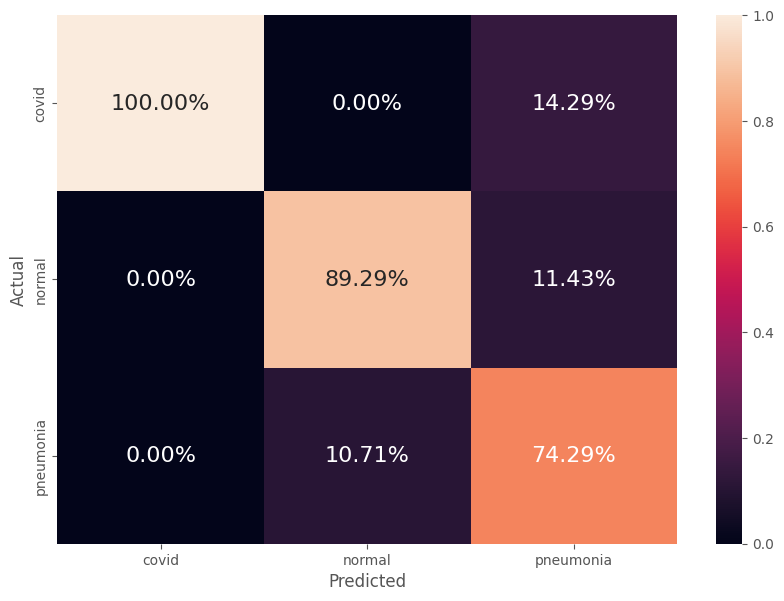

In [33]:
df_cm= pd.DataFrame(cm, columns=lb_encoder.classes_, index=lb_encoder.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

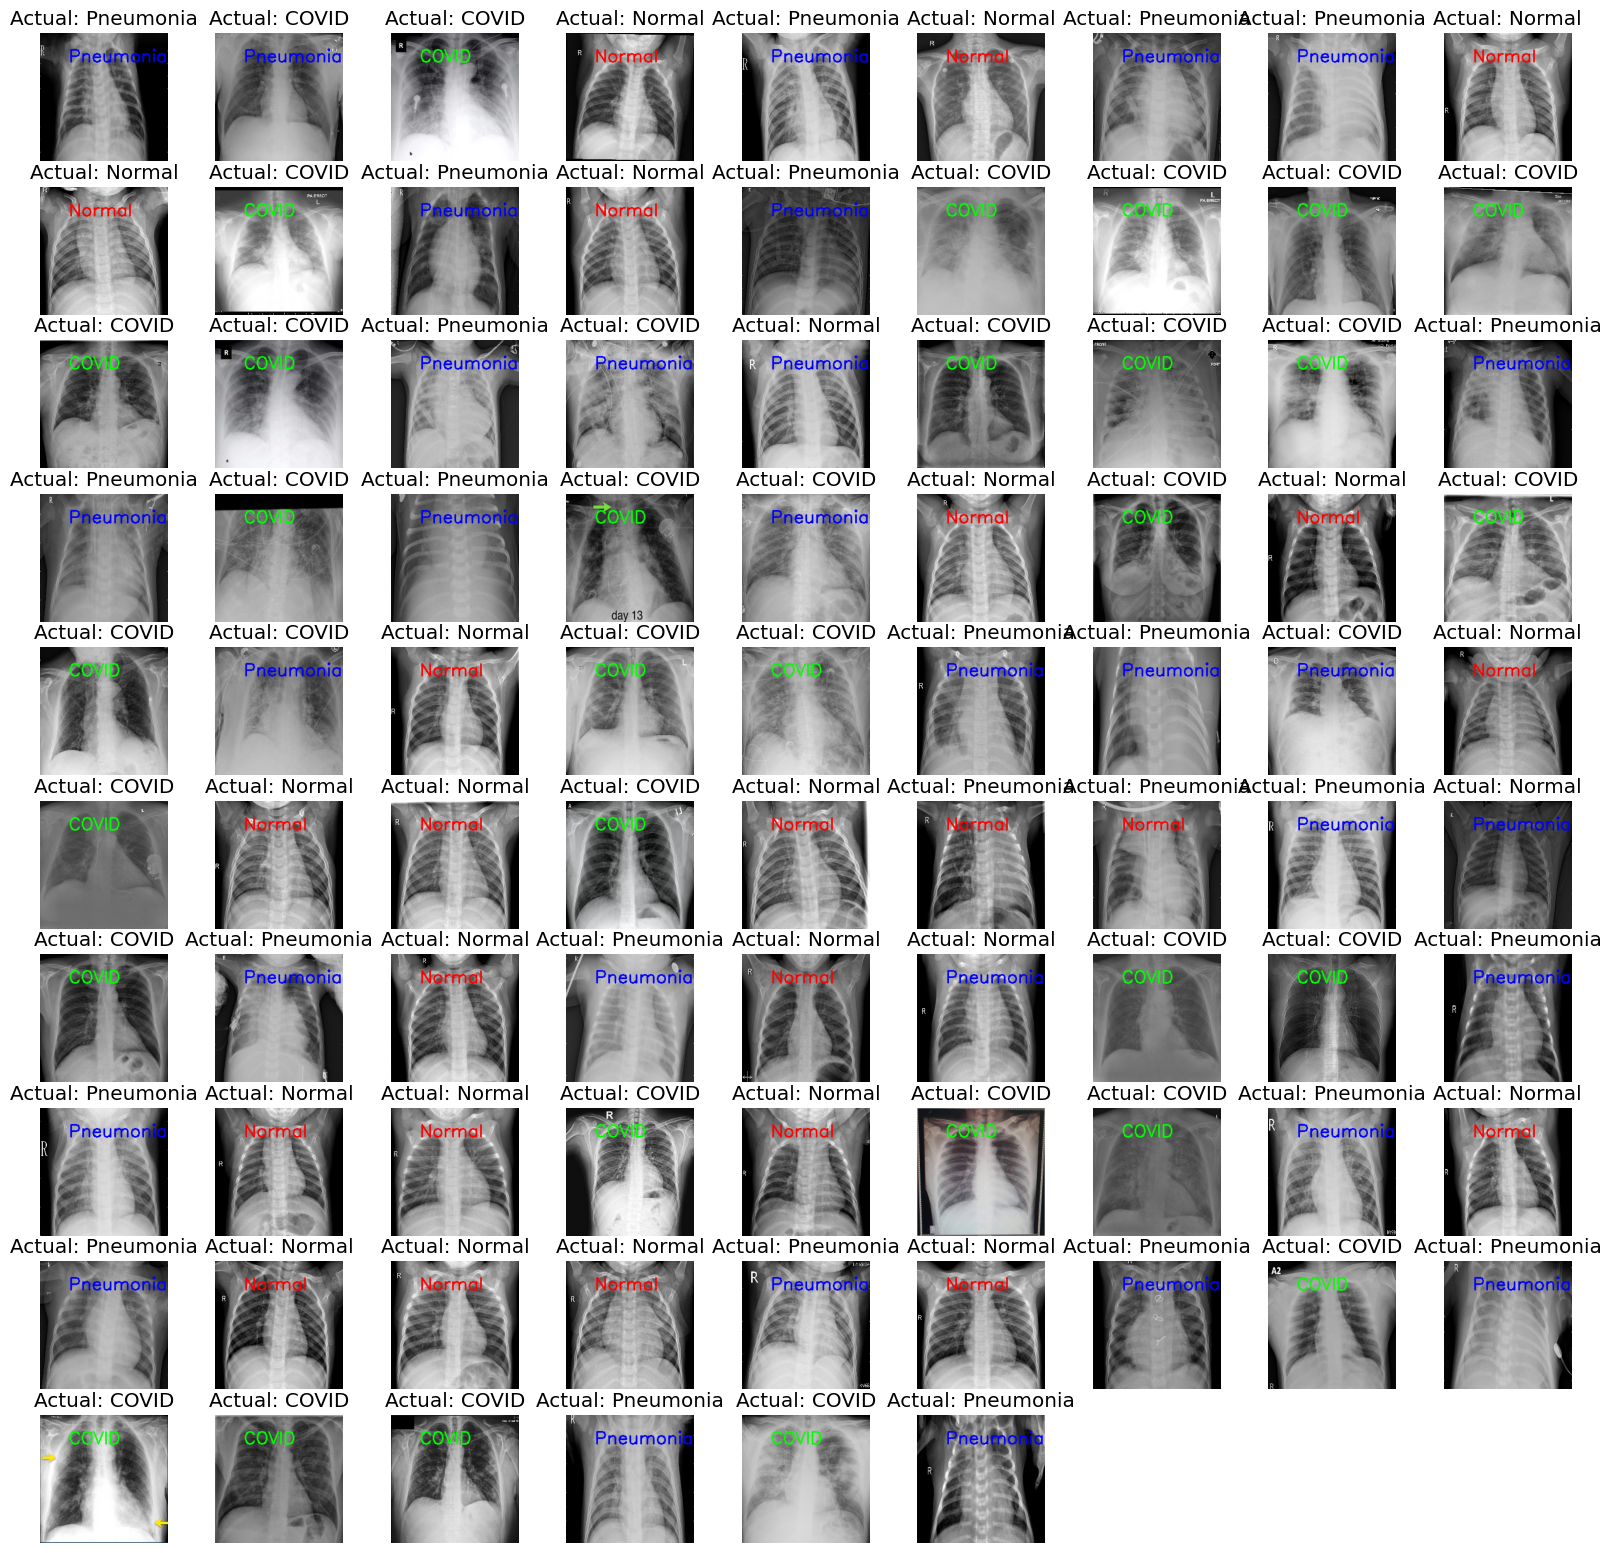

In [34]:
rows = 10
columns = 9
fig = plt.figure(figsize=(20, 20))
for m in range(1, 88):
    if str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
        
    if str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "covid":
        text2 = "COVID"
        color2 = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "normal":
        text2 = "Normal"
        color2 = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "pneumonia":
        text2 = "Pneumonia"
        color2 = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Actual: " + text2)
    plt.axis('off')
plt.show()